# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import requests
import os
import seaborn as sns
import datetime
import tweepy
from tweepy import OAuthHandler
import json
import zipfile as zf
from timeit import default_timer as timer

In [2]:
# Loading twitter_archive_enhance data using pandas library
df_weRateDogs = pd.read_csv('twitter_archive_enhanced.csv')

2. Use the tweepy library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# Loading tweet_image_predictions using requests library
#Downloading tweet_image_predictions programatically
tweet_image_predictions_url ='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
df_image = requests.get(tweet_image_predictions_url)
with open('tweet_image_predictions.tsv',mode='wb')as file:
    file.write(df_image.content)
    

In [4]:
#Reading tweet_image_predictions file
df_image_read = pd.read_csv('./tweet_image_predictions.tsv', sep='\t')

3. Query Twitter API for each tweet in the Twitter archive and save JSON in a text file


In [5]:
df_list =[]

with open('tweet-json.txt', 'r') as tweet_data:
    for line in tweet_data:
        data = json.loads(line)
        tweet_id = data['id']
        created_at = data['created_at']
        favorite_count = data['favorite_count']
        retweet_count = data['retweet_count']
        
# list of dictionaries to append
        df_list.append({'tweet_id': tweet_id,
                'created_at' : created_at,
                'favorite_count' : favorite_count,
                'retweet_count' : retweet_count})

df_Twitter_API = pd.DataFrame(df_list, columns=['tweet_id', 'created_at', 'favorite_count', 'retweet_count'])



In [6]:
df_Twitter_API.head()

,tweet_id,created_at,favorite_count,retweet_count
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,39467,8853
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,33819,6514
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,25461,4328
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,42908,8964
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,41048,9774


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Assessing twitter archive enhanced csv file defined as "df_weRateDogs"

In [7]:
df_weRateDogs.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [8]:
df_weRateDogs.shape

(2356, 17)

In [9]:
df_weRateDogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
df_weRateDogs.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [11]:
df_weRateDogs.isnull().sum().any()

True

In [12]:
df_weRateDogs.duplicated()

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
2326    False
2327    False
2328    False
2329    False
2330    False
2331    False
2332    False
2333    False
2334    False
2335    False
2336    False
2337    False
2338    False
2339    False
2340    False
2341    False
2342    False
2343    False
2344    False
2345    False
2346    False
2347    False
2348    False
2349    False
2350    False
2351    False
2352    False
2353    False
2354    False
2355    False
Length: 2356, dtype: bool

In [13]:
df_weRateDogs.duplicated().sum()

0

In [14]:
df_weRateDogs.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
df_weRateDogs[df_weRateDogs.rating_denominator==0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [16]:
df_weRateDogs[df_weRateDogs.rating_numerator==0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [17]:
df_weRateDogs[df_weRateDogs.rating_numerator>20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [18]:
df_weRateDogs.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [19]:
df_weRateDogs.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### Assessing image prediction tsv file defined as "df_image_read".

In [20]:
df_image_read.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1416,771136648247640064,https://pbs.twimg.com/media/CrOgsIBWYAA8Dtb.jpg,1,bathtub,0.368660,False,golden_retriever,0.297402,True,tub,0.201711,False
935,703407252292673536,https://pbs.twimg.com/media/CcMBJODUsAI5-A9.jpg,1,doormat,0.201058,False,turnstile,0.088583,False,carton,0.082924,False
1206,742150209887731712,https://pbs.twimg.com/media/CkylrVWWsAAiXJE.jpg,1,Siamese_cat,0.112413,False,French_bulldog,0.071414,True,hog,0.062465,False
1668,813051746834595840,https://pbs.twimg.com/media/C0iKPZIXUAAbDYV.jpg,1,golden_retriever,0.914804,True,Labrador_retriever,0.083550,True,kuvasz,0.000453,True
1593,798694562394996736,https://pbs.twimg.com/media/Cbs3DOAXIAAp3Bd.jpg,1,Chihuahua,0.615163,True,Pembroke,0.159509,True,basenji,0.084466,True
866,697482927769255936,https://pbs.twimg.com/media/Ca31BTgWwAA4uNU.jpg,1,bath_towel,0.110587,False,Christmas_stocking,0.108573,False,weasel,0.105442,False
1922,856543823941562368,https://pbs.twimg.com/media/C-MOEDCXYAEjp7o.jpg,1,Boston_bull,0.306910,True,Siamese_cat,0.191218,False,Chihuahua,0.189288,True
128,668274247790391296,https://pbs.twimg.com/media/CUYv4d2WUAAziXs.jpg,1,soft-coated_wheaten_terrier,0.406374,True,Lakeland_terrier,0.263854,True,toy_poodle,0.150844,True
2019,880465832366813184,https://pbs.twimg.com/media/DDgK-J4XUAIEV9W.jpg,1,golden_retriever,0.913255,True,Labrador_retriever,0.026329,True,cocker_spaniel,0.009371,True
547,677331501395156992,https://pbs.twimg.com/media/CWZdaGxXAAAjGjb.jpg,1,beagle,0.313464,True,boxer,0.218503,True,French_bulldog,0.106462,True


In [21]:
df_image_read.shape

(2075, 12)

In [22]:
df_image_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
type(df_image_read)

pandas.core.frame.DataFrame

In [24]:
type(df_image_read['jpg_url'][0])

str

In [25]:
df_image_read.duplicated().sum()

0

In [26]:
df_image_read.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [27]:
df_image_read.p1.unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher', 'Bernese_mountain_dog',
       'box_turtle', 'chow', 'shopping_cart', 'miniature_poodle',
       'golden_retriever', 'Gordon_setter', 'Walker_hound', 'pug',
       'bloodhound', 'Lhasa', 'English_setter', 'hen', 'desktop_computer',
       'Italian_greyhound', 'Maltese_dog', 'three-toed_sloth', 'ox',
       'malamute', 'guinea_pig', 'soft-coated_wheaten_terrier',
       'Chihuahua', 'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama', 'Chesapeake_Bay_retriever',
       'curly-coated_retriever', 'dalmatian', 'Ibizan_hound',
       'Border_collie', 'Labrador_retriever', 'seat_belt', 'snail',
       'miniature_schnauzer', 'Airedale', 'triceratops', 'swab', 'hay',
       'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 'teddy', 

In [28]:
df_image_read.p1.nunique()

378

### Asssessing tweet-json file defined as "df_Twitter_API"

In [29]:
df_Twitter_API.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null int64
created_at        2354 non-null object
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


In [30]:
df_Twitter_API.shape

(2354, 4)

In [31]:
df_Twitter_API.describe()

,tweet_id,favorite_count,retweet_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


In [32]:
df_Twitter_API.duplicated()

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
2324    False
2325    False
2326    False
2327    False
2328    False
2329    False
2330    False
2331    False
2332    False
2333    False
2334    False
2335    False
2336    False
2337    False
2338    False
2339    False
2340    False
2341    False
2342    False
2343    False
2344    False
2345    False
2346    False
2347    False
2348    False
2349    False
2350    False
2351    False
2352    False
2353    False
Length: 2354, dtype: bool

In [33]:
df_Twitter_API.duplicated().sum()

0

### Quality issues
1. The "tweet_id" datatype should be string and not int64 (integer).

2. There are many Null Values in "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", and "retweeted_status_timestamp.
3. The "timestamp" datatype should be DateTime and not Object.

4. Some "rating_denominator" are not "10" while the standared rating_denominator is "10"

5. Not all tweet have rating, we have "0" rating value.

6. There should be a single column named 'rating'. Therefore rating_numerator and rating_denominator should be solved into a single column.

7. We do not need "href" in the "source" column information, we therefore extract only the needed address from the source column. 

8. We have incorrect names in the "name" column.

### Tidiness issues
1. The three DataFrames need to be combined 

2. We only need one column for the dog categories. Therefore, "doggo", "floofer", "pupper" and "puppo" in different columns should be combined into one column

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [34]:
# Make copies of original pieces of data

df_weRateDogs_new = df_weRateDogs.copy()
df_image_read_new = df_image_read.copy()
df_Twitter_API_new =df_Twitter_API.copy()

### Tidiness Issue 1:

### Define: Combining i.e, merging the DataFrames

#### Code

In [35]:
df_all = [df_weRateDogs,df_image_read, df_Twitter_API]

In [36]:
from functools import reduce

df_merged = reduce(lambda left,right: pd.merge(left,right,on=['tweet_id'],
        how ='outer'),df_all).fillna('none')

#### Test

In [37]:
df_merged.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,created_at,favorite_count,retweet_count
0,892420643555336193,none,none,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,none,none,none,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.0858511,False,banana,0.07611,False,Tue Aug 01 16:23:56 +0000 2017,39467,8853
1,892177421306343426,none,none,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,none,none,none,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.0906465,True,papillon,0.0689569,True,Tue Aug 01 00:17:27 +0000 2017,33819,6514
2,891815181378084864,none,none,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,none,none,none,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.0313789,True,Mon Jul 31 00:18:03 +0000 2017,25461,4328
3,891689557279858688,none,none,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,none,none,none,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.168086,True,spatula,0.0408359,False,Sun Jul 30 15:58:51 +0000 2017,42908,8964
4,891327558926688256,none,none,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,none,none,none,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.22577,True,German_short-haired_pointer,0.175219,True,Sat Jul 29 16:00:24 +0000 2017,41048,9774


In [38]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    2356 non-null object
expanded_urls                 2356 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                      

In [39]:
df_merged.describe()

,tweet_id,rating_numerator,rating_denominator
count,2.356000e+03,2356.000000,2356.000000
mean,7.427716e+17,13.126486,10.455433
std,6.856705e+16,45.876648,6.745237
min,6.660209e+17,0.000000,0.000000
25%,6.783989e+17,10.000000,10.000000
50%,7.196279e+17,11.000000,10.000000
75%,7.993373e+17,12.000000,10.000000
max,8.924206e+17,1776.000000,170.000000


In [40]:
df_merged.shape

(2356, 31)

### Tidiness Issue 2:

### Define:
### We only need one column for the dog categories. Therefore, "doggo", "floofer", "pupper" and "puppo" in different columns should be combined into one column

#### Code

In [41]:
# concatenating the columns
df_merged['dog_stage'] = df_merged.doggo + df_merged.floofer + df_merged.pupper + df_merged.puppo

In [42]:
df_merged.dog_stage.unique()

array(['NoneNoneNoneNone', 'doggoNoneNoneNone', 'NoneNoneNonepuppo',
       'NoneNonepupperNone', 'NoneflooferNoneNone', 'doggoNoneNonepuppo',
       'doggoflooferNoneNone', 'doggoNonepupperNone'], dtype=object)

In [43]:
# assigning each concatenated record a value
df_merged.loc[df_merged.dog_stage == 'NoneNoneNoneNone', 'dog_stage'] = np.nan
df_merged.loc[df_merged.dog_stage == 'doggoNoneNoneNone', 'dog_stage'] = 'doggo'
df_merged.loc[df_merged.dog_stage == 'NoneNoneNonepuppo', 'dog_stage'] = 'puppo'
df_merged.loc[df_merged.dog_stage == 'NoneNonepupperNone', 'dog_stage'] = 'pupper'
df_merged.loc[df_merged.dog_stage == 'NoneflooferNoneNone', 'dog_stage'] = 'floofer'
df_merged.loc[df_merged.dog_stage == 'doggoNoneNonepuppo', 'dog_stage'] = 'doggopuppo'
df_merged.loc[df_merged.dog_stage == 'doggoNonepupperNone', 'dog_stage'] = 'doggopupper'
df_merged.loc[df_merged.dog_stage == 'doggoflooferNoneNone', 'dog_stage'] = 'doggofloofer'

In [44]:
unwanted_record = ['doggopupper', 'doggopuppo', 'doggofloofer']

# using loops to replace the record to Indefinite
for dog_stage in df_merged.dog_stage:
    if dog_stage in unwanted_record:
        df_merged_dog_stage = df_merged['dog_stage'].replace(unwanted_record,'indefinite')

In [45]:
df_merged.dog_stage.value_counts()

pupper          245
doggo            83
puppo            29
doggopupper      12
floofer           9
doggofloofer      1
doggopuppo        1
Name: dog_stage, dtype: int64

### Quality Issue 1:

### Define:  The "tweet_id" datatype should be string and not int64 (integer).


#### Code

In [46]:
tweet_id =df_merged.tweet_id.astype(str)

#### Test

In [47]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 32 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    2356 non-null object
expanded_urls                 2356 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                      

### Quality Issue 2: 

### Define

### There are many Null Values in "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", and "retweeted_status_timestamp

### We only need the real tweet and not retweet, we therefore drop the above mentioned columns

#### Code

In [48]:
df_merged = df_merged.drop(['retweet_count', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

#### Test

In [49]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 26 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
jpg_url               2356 non-null object
img_num               2356 non-null object
p1                    2356 non-null object
p1_conf               2356 non-null object
p1_dog                2356 non-null object
p2                    2356 non-null object
p2_conf               2356 non-null object
p2_dog                2356 non-null object
p3                    2356 non-null 

### Quality Issue 3: 

### Define
### The "timestamp" datatype should be DateTime and not Object

#### Code

In [50]:
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])


### Quality Issue 4: 

### Define
### Some "rating_denominator" are not "10" while the standared rating_denominator is "10"

### We therefore drop rating_denominators that are not equal to 10

#### Code

In [51]:
df_merged.query('rating_denominator !=10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,created_at,favorite_count,dog_stage
313,835246439529840640,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,none,960,0,None,None,None,...,none,none,none,none,none,none,none,Fri Feb 24 21:54:03 +0000 2017,2259,NaN
342,832088576586297345,2017-02-16 04:45:50,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,none,11,15,None,None,None,...,none,none,none,none,none,none,none,Thu Feb 16 04:45:50 +0000 2017,72,NaN
433,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,...,True,kuvasz,0.0595259,True,Samoyed,0.0373996,True,Sun Jan 15 17:52:40 +0000 2017,13518,NaN
516,810984652412424192,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,...,True,Tibetan_mastiff,0.0367077,True,Labrador_retriever,0.0258232,True,Mon Dec 19 23:06:23 +0000 2016,5927,NaN
784,775096608509886464,2016-09-11 22:20:06,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,...,none,none,none,none,none,none,none,Sun Sep 11 22:20:06 +0000 2016,0,NaN
902,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,...,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.0996891,True,Thu Jul 28 01:00:57 +0000 2016,5316,NaN
1068,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,...,True,kuvasz,0.101286,True,Labrador_retriever,0.0237853,True,Wed Jun 08 02:41:38 +0000 2016,20648,NaN
1120,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,...,False,breakwater,0.0513506,False,king_penguin,0.0494438,False,Fri May 13 16:15:54 +0000 2016,4196,NaN
1165,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,...,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.0852969,True,Thu Apr 21 02:25:47 +0000 2016,4493,NaN
1202,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,...,True,malamute,0.317053,True,Eskimo_dog,0.273419,True,Sun Apr 03 01:36:11 +0000 2016,2574,NaN


In [52]:
df_merged.drop(df_merged.query('rating_denominator != 10').index, axis = 'index', inplace = True)

#### Test

In [53]:
df_merged.query('rating_denominator !=10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,created_at,favorite_count,dog_stage


### Quality Issue 5: 

### Define
### There should be a single column named 'rating'. Therefore rating_numerator and rating_denominator will be solved into a single column.


#### Code

In [54]:
df_merged['rating'] = round(df_merged['rating_numerator'] / df_merged['rating_denominator'],2)

#### Test

In [55]:
df_merged['rating'].value_counts()

1.2      558
1.1      463
1.0      461
1.3      351
0.9      156
0.8      102
0.7       54
1.4       54
0.5       37
0.6       32
0.3       19
0.4       15
0.2        9
0.1        8
0.0        2
42.0       2
1.5        2
7.5        2
66.6       1
2.6        1
177.6      1
18.2       1
1.7        1
2.7        1
Name: rating, dtype: int64

### Quality Issue 6: 

### Define
###  Not all tweet have rating, we have "0" rating value.

#### Code

In [56]:
zero_rating = df_merged.query('rating_denominator==0').index

In [57]:
df_merged.drop(df_merged.index[zero_rating],axis='index', inplace = True)

#### Test

In [58]:
zero_rating = df_merged.query('rating_denominator==0')

In [59]:
zero_rating.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,created_at,favorite_count,dog_stage,rating


### Quality Issue 7: 

### Define
### We do not need "href" in the "source" column information, we therefore extract only the needed address from the source column.

#### Code

In [60]:
df_merged.source.unique()

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'], dtype=object)

In [61]:
df_merged['source'] = df_merged['source'].str.extract('^<a.+>(.+)</a>$')

#### Test

In [62]:
df_merged.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

In [63]:
df_merged.source.value_counts()

Twitter for iPhone     2198
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

### Quality Issue 8:

### Define
### We have incorrect names in the "name" column 

#### Code

In [64]:
# Checking the name variables
df_merged.name.value_counts()

None          728
a              54
Charlie        12
Lucy           11
Cooper         11
Oliver         11
Tucker         10
Penny          10
Lola           10
Winston         9
Bo              9
Sadie           8
the             8
Toby            7
Bailey          7
Daisy           7
Buddy           7
Dave            6
Scout           6
Stanley         6
Leo             6
Jax             6
Rusty           6
Jack            6
Milo            6
an              6
Koda            6
Oscar           6
Bella           6
Phil            5
             ... 
Zuzu            1
Ulysses         1
Birf            1
Sunshine        1
Stu             1
Ace             1
Fillup          1
Jersey          1
Dobby           1
Rinna           1
incredibly      1
his             1
Jimbo           1
Mike            1
DonDon          1
Ronnie          1
Juckson         1
Arlen           1
Alfy            1
Chubbs          1
Zeus            1
Sora            1
Filup           1
Ike             1
Margo     

In [65]:
incorrect_record = ['None', 'a']
for name in df_merged.name:
        if name in incorrect_record:
            df_merged_name = df_merged['name'].replace(incorrect_record, 'incorrect_names')
            

In [66]:
df_merged.name.value_counts()

None          728
a              54
Charlie        12
Lucy           11
Cooper         11
Oliver         11
Tucker         10
Penny          10
Lola           10
Winston         9
Bo              9
Sadie           8
the             8
Toby            7
Bailey          7
Daisy           7
Buddy           7
Dave            6
Scout           6
Stanley         6
Leo             6
Jax             6
Rusty           6
Jack            6
Milo            6
an              6
Koda            6
Oscar           6
Bella           6
Phil            5
             ... 
Zuzu            1
Ulysses         1
Birf            1
Sunshine        1
Stu             1
Ace             1
Fillup          1
Jersey          1
Dobby           1
Rinna           1
incredibly      1
his             1
Jimbo           1
Mike            1
DonDon          1
Ronnie          1
Juckson         1
Arlen           1
Alfy            1
Chubbs          1
Zeus            1
Sora            1
Filup           1
Ike             1
Margo     

In [67]:
# Removing the lowercase in 'name' column
lowercase = df_merged.name.str.islower()
column_name = 'name'

In [68]:
# Replacing lowercase values to null values
df_merged.loc[lowercase, column_name] = np.nan

In [69]:
# Replacing 'name' with None values with null values
df_merged.name.replace('None', np.nan, inplace=True)

#### Test

In [70]:
df_merged.name.value_counts()

Charlie      12
Oliver       11
Lucy         11
Cooper       11
Penny        10
Tucker       10
Lola         10
Bo            9
Winston       9
Sadie         8
Bailey        7
Buddy         7
Daisy         7
Toby          7
Koda          6
Oscar         6
Dave          6
Scout         6
Milo          6
Bella         6
Stanley       6
Rusty         6
Leo           6
Jax           6
Jack          6
Chester       5
Louis         5
Alfie         5
Larry         5
Finn          5
             ..
Tommy         1
Lilli         1
Bodie         1
Zuzu          1
Ulysses       1
Birf          1
Gin           1
Kawhi         1
Kaiya         1
Herb          1
Wesley        1
Claude        1
Bobby         1
Jersey        1
Rinna         1
Ito           1
Jimbo         1
Mike          1
DonDon        1
Ronnie        1
Juckson       1
Arlen         1
Dobby         1
Alfy          1
Zeus          1
Sora          1
Filup         1
Ike           1
Margo         1
Alejandro     1
Name: name, Length: 929,

In [71]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id              2333 non-null int64
timestamp             2333 non-null datetime64[ns]
source                2333 non-null object
text                  2333 non-null object
expanded_urls         2333 non-null object
rating_numerator      2333 non-null int64
rating_denominator    2333 non-null int64
name                  1499 non-null object
doggo                 2333 non-null object
floofer               2333 non-null object
pupper                2333 non-null object
puppo                 2333 non-null object
jpg_url               2333 non-null object
img_num               2333 non-null object
p1                    2333 non-null object
p1_conf               2333 non-null object
p1_dog                2333 non-null object
p2                    2333 non-null object
p2_conf               2333 non-null object
p2_dog                2333 non-null object
p3                    2333 n

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [72]:
# Saving the cleaned DataFrame as CSV file
df_merged.to_csv('df_weRateDogs_master', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [73]:
# Checking the cleaned data before analyzing
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id              2333 non-null int64
timestamp             2333 non-null datetime64[ns]
source                2333 non-null object
text                  2333 non-null object
expanded_urls         2333 non-null object
rating_numerator      2333 non-null int64
rating_denominator    2333 non-null int64
name                  1499 non-null object
doggo                 2333 non-null object
floofer               2333 non-null object
pupper                2333 non-null object
puppo                 2333 non-null object
jpg_url               2333 non-null object
img_num               2333 non-null object
p1                    2333 non-null object
p1_conf               2333 non-null object
p1_dog                2333 non-null object
p2                    2333 non-null object
p2_conf               2333 non-null object
p2_dog                2333 non-null object
p3                    2333 n

In [74]:
df_merged.shape

(2333, 27)

In [75]:
df_merged.describe()

,tweet_id,rating_numerator,rating_denominator,rating
count,2.333000e+03,2333.000000,2333.0,2333.000000
mean,7.429280e+17,12.237462,10.0,1.223746
std,6.869187e+16,41.022472,0.0,4.102247
min,6.660209e+17,0.000000,10.0,0.000000
25%,6.783802e+17,10.000000,10.0,1.000000
50%,7.200432e+17,11.000000,10.0,1.100000
75%,7.997580e+17,12.000000,10.0,1.200000
max,8.924206e+17,1776.000000,10.0,177.600000


In [76]:
df_merged.isnull()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,created_at,favorite_count,dog_stage,rating
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
5,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fce120518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3fcc002ef0>]], dtype=object)

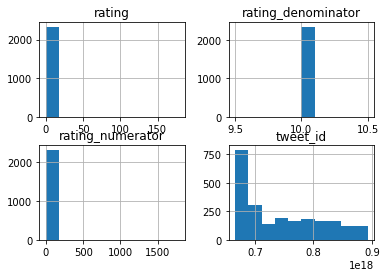

In [77]:
df_merged.hist()

### Insights:
1. The most popular dog name is "Charlie" with  "11" counts, Other popular dog names are "Cooper", "Lucy", "Tucker", "Oliver" and "Penny" with "10" counts.

2. The mostly used source is "Twitter for iphone".

3. In the dog stages analysis, "Pupper" has the highest counts

### Visualization

### Most Popular Dog Name

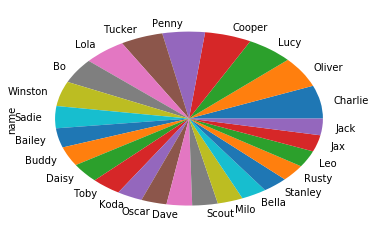

In [78]:
#Plot
df_merged.name.value_counts() [:25].plot.pie()

### Visualizing source count

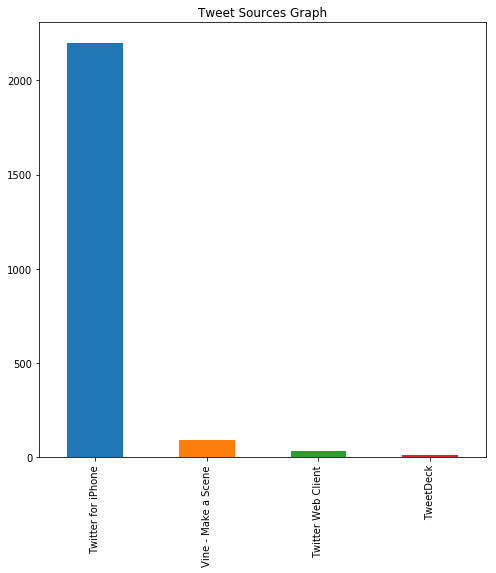

In [79]:
# A bar graph to show "source" value_counts
df_merged.source.value_counts().plot(kind = 'bar', figsize = (8,8), title = 'Tweet Sources Graph', x = 'source', y = 'expanded_urls')

### Dog Stages Analysis

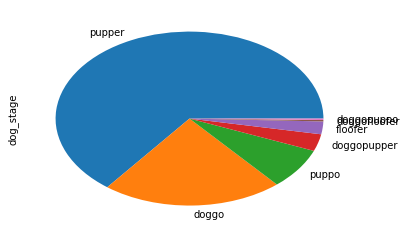

In [80]:
df_merged.dog_stage.value_counts().plot.pie()

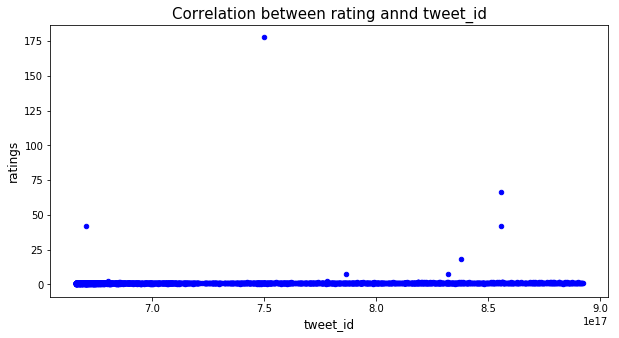

In [81]:
df_merged.plot(x='tweet_id', y='rating', kind='scatter',color='blue', figsize=(10,5))
plt.title('Correlation between rating annd tweet_id', fontsize=15)
plt.xlabel('tweet_id', fontsize=12)
plt.ylabel('ratings', fontsize=12)
plt.show()

### Visualizing Timestamp and Source

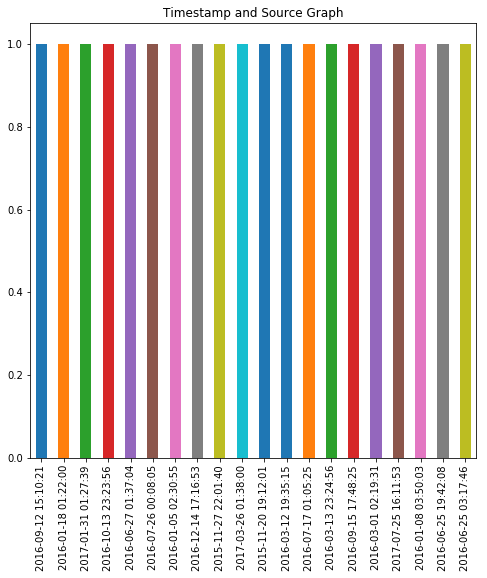

In [82]:

df_merged.timestamp.value_counts() [:20].plot(kind = 'bar', figsize = (8,8), title = 'Timestamp and Source Graph', x = 'timestamp', y = 'source')

In [83]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id              2333 non-null int64
timestamp             2333 non-null datetime64[ns]
source                2333 non-null object
text                  2333 non-null object
expanded_urls         2333 non-null object
rating_numerator      2333 non-null int64
rating_denominator    2333 non-null int64
name                  1499 non-null object
doggo                 2333 non-null object
floofer               2333 non-null object
pupper                2333 non-null object
puppo                 2333 non-null object
jpg_url               2333 non-null object
img_num               2333 non-null object
p1                    2333 non-null object
p1_conf               2333 non-null object
p1_dog                2333 non-null object
p2                    2333 non-null object
p2_conf               2333 non-null object
p2_dog                2333 non-null object
p3                    2333 n